<a href="https://colab.research.google.com/github/sirr890/Cell-Segmentation/blob/main/CellSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#.... Download data set...
!wget http://data.celltrackingchallenge.net/training-datasets/Fluo-N2DH-GOWT1.zip

#...Unzip...
!unzip Fluo-N2DH-GOWT1.zip

In [ ]:
!pip install imagecodecs

torch.Size([1, 256, 256]) torch.Size([256, 256])


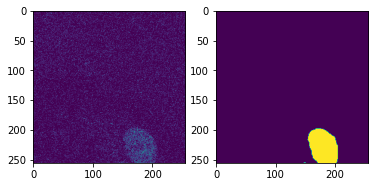

In [ ]:
#...Create DataLoader...

import torch
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import numpy as np
import imageio
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
from torchvision import transforms, utils
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image


class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image = sample[0]
        landmarks = sample[1]
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        image = image[top: top + new_h,
                      left: left + new_w]
        landmarks = landmarks[top: top + new_h,
                      left: left + new_w]
        return image, landmarks

class RandomRotation(object):
    def __init__(self, angle):
        self.angle = angle
    def __call__(self, sample):
        image = sample[0]
        landmarks = sample[1]
        h, w = image.shape[:2]
        angle=np.random.randint(-self.angle,self.angle)
        image = transform.rotate(image, angle)
        landmarks = transform.rotate(landmarks, angle)
        return image, landmarks

class ColorJitterT(object):
    def __init__(self, brightness,contrast,saturation,hue=(0,0)):
        self.transf = transforms.ColorJitter(brightness=brightness,contrast=contrast,saturation=saturation,hue=hue)
    def __call__(self, sample):
        image = sample[0]
        landmarks = sample[1]
        image=self.transf(torch.from_numpy(image).unsqueeze(0)).numpy()[0,:,:]
        return image, landmarks

class MyCell(Dataset):
  def __init__(self, ind_init, ind_final, transform=None):
    super().__init__()
    seg_path = []
    gt_path = []
    for seq in range(ind_init,ind_final):
      number_str = str(seq)
      zero_filled_number = number_str.zfill(3)
      str_path = 'Fluo-N2DH-GOWT1/01/t'+zero_filled_number+'.tif'
      seg_path.append(str_path)
      str_path = 'Fluo-N2DH-GOWT1/02/t'+zero_filled_number+'.tif'
      seg_path.append(str_path)
      str_path = 'Fluo-N2DH-GOWT1/01_ST/SEG/man_seg'+zero_filled_number+'.tif'
      gt_path.append(str_path)
      str_path = 'Fluo-N2DH-GOWT1/02_ST/SEG/man_seg'+zero_filled_number+'.tif'
      gt_path.append(str_path)
    self.seg_path = seg_path
    self.gt_path = gt_path
    self.leng = ind_final-ind_init
    self.transform = transform

  def __len__(self):
    return self.leng

  def __getitem__(self, index):
    img = imageio.imread(self.seg_path[index])/255.0       
    x = imageio.imread(self.gt_path[index])>0.0
    if self.transform:
            sample = [img, x]
            img, x = self.transform(sample)
    img = torch.from_numpy(img).float().unsqueeze(0) 
    x = torch.from_numpy(x).long()
    return img, x


total_train = 80

#...Data aumentation
dataset = MyCell(0,total_train,transform=transforms.Compose([                                                
                                                #ColorJitterT((0.5,1.5),1,(0.5,1.5)),        
                                                #RandomRotation(180),                                        
                                                RandomCrop(256)            
                                                
                                            ]))
img, x = dataset[0]
print(img.shape,x.shape)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img[0,:,:])
axarr[1].imshow(x)
TrainSet = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)

In [ ]:
#...Unet implementation...

import torch.nn as nn
import torch.nn.functional as F

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
#... Train Unet...

import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

learning_rate = 1e-5
n_epochs = 500

net = UNet(2)
device = torch.device('cuda:0')
net = net.to(device)
criterion = nn.L1Loss()
criterion = criterion.to(device)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
writer = SummaryWriter()

for epoch in range(n_epochs):  # loop over the dataset
    running_loss = 0.0
    for i, data in enumerate(TrainSet):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i == 0):
          writer.add_scalar('Loss/epoch',loss.item(), epoch)
          writer.add_image('labels', labels.unsqueeze(1)[0,:,:,:], epoch)
          writer.add_image('input', inputs[0,:,:,:], epoch)
          writer.add_image('outputs', outputs[0,...], epoch)
          writer.flush()
          if (epoch%100==0 and epoch!=0): #...save model every 100 epochs...
            torch.save({'net':net.state_dict()},'unet'+str(epoch)+'.pt')

tensor(95.6918, device='cuda:0')


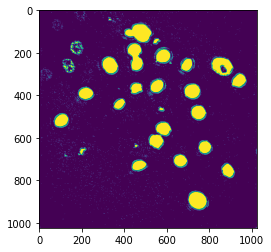

In [30]:
#... Test Images...
net = UNet(2)

device = torch.device('cuda:0')
net = net.to(device)

st = torch.load('unet400.pt')
weights = st['net']
net.load_state_dict(weights)

net.eval()

test_init = 81
test_final = 92
Total_accuracy = 0
Total_images=0
dataset = MyCell(test_init, test_final)    
for i, data in enumerate(dataset):                            
  images, labels = data
  images = images.unsqueeze(0) 

  images = images.to(device)
  labels = labels.to(device)

  logit = net(images)
  final = torch.softmax(logit,1)
  _, predicted = torch.max(final, 1)
  total = labels.shape[0]*labels.shape[1]
  correct = (predicted == labels).sum()
  accuracy = correct / total
  Total_accuracy+=accuracy
  Total_images+=1

plt.imshow(predicted.to('cpu')[0,...])
#...print accuracy total...
print(100 * Total_accuracy/Total_images)